<a href="https://colab.research.google.com/github/eneskosar/Tensorflow-CNN-Face-Attractiveness-/blob/master/TensorFlowCNN8_complex_DropRegularization_Xavier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time

import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

print(tf.__version__)


TensorFlow 1.x selected.
1.15.2


# My Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

In [ ]:
trainDirectory = '/content/gdrive/My Drive/Colab Notebooks/DeepLearningHomework/training/'
validationDirectory = '/content/gdrive/My Drive/Colab Notebooks/DeepLearningHomework/validation/'
testDirectory = '/content/gdrive/My Drive/Colab Notebooks/DeepLearningHomework/test/'

In [ ]:
trainImageNames = os.listdir(trainDirectory)
validationImageNames = os.listdir(validationDirectory)
testImageNames = os.listdir(testDirectory)

In [ ]:
random.shuffle(trainImageNames)
random.shuffle(validationImageNames)
random.shuffle(testImageNames)

testLabels = np.zeros((len(testImageNames), 1))
validationLabels = np.zeros((len(validationImageNames), 1))
trainLabels = np.zeros((len(trainImageNames), 1))

trainLabels2 = [x[0] for x in trainImageNames]
validationLabels2 = [x[0] for x in validationImageNames]
testLabels2 = [x[0] for x in testImageNames]

i = 0
for names in trainImageNames:
  trainLabels[i] = trainLabels2[i]    
  i +=1

i = 0
for names in validationImageNames:
  validationLabels[i] = validationLabels2[i]    
  i +=1

i = 0
for names in testImageNames:
  testLabels[i] = testLabels2[i]    
  i +=1

trainLabels = np.float32(trainLabels)
validationLabels = np.float32(validationLabels)
testLabels = np.float32(testLabels)

In [ ]:
testData = np.zeros((len(testImageNames), 80*80*3))
validationData = np.zeros((len(validationImageNames), 80*80*3))
trainData = np.zeros((len(trainImageNames), 80*80*3))

i = 0
for names in trainImageNames:
  trainData[i] = mpimg.imread(trainDirectory + names).flatten()    
  i +=1
trainData = trainData.astype(np.float32)

i = 0
for names in validationImageNames:
  validationData[i] = mpimg.imread(validationDirectory + names).flatten()    
  i +=1
validationData = validationData.astype(np.float32)

i = 0
for names in testImageNames:
  testData[i] = mpimg.imread(testDirectory + names).flatten()    
  i +=1
testData = testData.astype(np.float32)

# CNN Implementation

In [ ]:
#optimization variables

epochNumber = 20
learningRate = 0.0001
batchSize = 100
beta = 0.01

# input
x = tf.placeholder(tf.float32, [None, 80*80*3])
# dynamically reshape the input
x_shaped = tf.reshape(x, [-1, 80, 80, 3])
# output  
y = tf.placeholder(tf.float32, [None, 1])


In [ ]:
def create_conv_ReLu_Pooling_layers(input_data, num_input_channels, num_filters, filter_shape, pool_shape, name):
    # setup the filter input shape for tf.nn.conv_2d
    conv_filt_shape = [filter_shape[0], filter_shape[1], num_input_channels,
                      num_filters]

    # initialise weights and bias for the filter
    weights = tf.Variable(tf.truncated_normal(conv_filt_shape, stddev=0.03),
                                      name=name+'_W')
    bias = tf.Variable(tf.truncated_normal([num_filters]), name=name+'_b')

    # setup the convolutional layer operation
    out_layer = tf.nn.conv2d(input_data, weights, [1, 1, 1, 1], padding='SAME')

    # add the bias
    out_layer += bias

    # apply a ReLU non-linear activation
    out_layer = tf.nn.relu(out_layer)

    # now perform max pooling
    ksize = [1, pool_shape[0], pool_shape[1], 1]
    strides = [1, 2, 2, 1]
    out_layer = tf.nn.max_pool(out_layer, ksize=ksize, strides=strides, 
                               padding='SAME')

    return out_layer

In [ ]:
# create some convolutional layers
layer1 = create_conv_ReLu_Pooling_layers(x_shaped, 3, 18, [5, 5], [2, 2], name='layer1')
layer2 = create_conv_ReLu_Pooling_layers(layer1, 18, 72, [5, 5], [2, 2], name='layer2')
layer3 = create_conv_ReLu_Pooling_layers(layer2, 72, 288, [3, 3], [2, 2], name='layer3')
layer4 = create_conv_ReLu_Pooling_layers(layer3, 288, 576, [3, 3], [2, 2], name='layer4')

In [ ]:
flattened = tf.reshape(layer4, [-1, 5 * 5 *3*6*4*4*2])


In [ ]:
# setup some weights and bias values for this layer, then activate with ReLU
wd1 = tf.Variable(tf.truncated_normal([5*5*3*6*4*4*2 , 2000], stddev= (2.0/ (5*5*3*6*4*4*2+2000))), name='wd1')
bd1 = tf.Variable(tf.truncated_normal([2000], stddev=0.01), name='bd1')
dense_layer1 = tf.matmul(flattened, wd1) + bd1
dense_layer1 = tf.nn.relu(dense_layer1)

# Dropout on hidden layer: RELU layer
keep_prob = tf.placeholder(tf.float32)
dense_layer1_dropout = tf.nn.dropout(dense_layer1, keep_prob)

In [ ]:
wd2 = tf.Variable(tf.truncated_normal([2000, 100], stddev=(2.0/(2000+100))), name='wd2')
bd2 = tf.Variable(tf.truncated_normal([100], stddev=0.01), name='bd2')
dense_layer2 = tf.matmul(dense_layer1_dropout, wd2) + bd2
dense_layer2 = tf.nn.relu(dense_layer2)

#keep_prob = tf.placeholder("float")
dense_layer2_dropout = tf.nn.dropout(dense_layer2, keep_prob)

In [ ]:
wd3 = tf.Variable(tf.truncated_normal([100, 10], stddev=(2/(100+10))), name='wd3')
bd3 = tf.Variable(tf.truncated_normal([10], stddev=0.01), name='bd3')
dense_layer3 = tf.matmul(dense_layer2_dropout, wd3) + bd3
dense_layer3 = tf.nn.relu(dense_layer3)

dense_layer3_dropout = tf.nn.dropout(dense_layer3, keep_prob)

In [ ]:
wd4 = tf.Variable(tf.truncated_normal([10, 1], stddev=(2/(10+1))), name='wd4')
bd4 = tf.Variable(tf.truncated_normal([1], stddev=0.01), name='bd4')
dense_layer4 = tf.matmul(dense_layer3_dropout, wd4) + bd4
y_ = 8*tf.nn.sigmoid(dense_layer4)



In [ ]:
#MSE = tf.metrics.mean_squared_error(labels=y, predictions=y_ )
MSE = tf.reduce_mean(tf.square(y_ - y))



In [ ]:
MAE = tf.reduce_mean(tf.abs(y-tf.math.round(y_)))

In [ ]:
# add an optimiser
#optimiser = tf.train.GradientDescentOptimizer(0.0001).minimize(MSE)
optimiser = tf.train.AdamOptimizer(learning_rate=learningRate).minimize(MSE)


# setup the initialisation operator
init_op = tf.global_variables_initializer()

with tf.Session() as sess:
    # initialise the variables
    sess.run(init_op)
    total_batch = int(len(trainLabels) / batchSize)
    start_time = time.time()
    train_MAE_EpochArray = np.zeros(epochNumber)
    validate_MAE_EpochArray = np.zeros(epochNumber)
    
    for epoch in range(epochNumber):
        epoch_start_time = time.time()
        avg_cost = 0
        totalTrainMae = 0
        totalValidateMae = 0
        for batch in range(0, int(len(trainLabels) /batchSize)):
            x_batch = trainData[batch*batchSize:(batch+1)*batchSize,:]  
            y_batch = trainLabels[batch*batchSize:(batch+1)*batchSize]  
            
            feed_dict_train = {x: x_batch, y: y_batch}

            #_, c , TrainMae, pred = sess.run([optimiser, MSE, MAE, y_], 
            #                feed_dict={x: x_batch, y: y_batch})
            
            _= sess.run([optimiser], 
                            feed_dict={keep_prob : 0.75, x: x_batch, y: y_batch})
            
            #avg_cost += c / total_batch
            print("batch:", (batch + 1), "mae =", "{:.3f}".format(8.0))
            #ValidateMae= sess.run(MAE, feed_dict={x: validationData, y: validationLabels})
            #print(ValidateMae)
            #totalTrainMae += TrainMae/35.6
            #totalValidateMae += ValidateMae/35.0
            
        ValidateMae= sess.run(MAE, feed_dict={keep_prob : 1.0, x: validationData, y: validationLabels})
        totalTrainMae= sess.run(MAE, feed_dict={keep_prob : 0.75, x: trainData, y: trainLabels})
        print("Epoch:", (epoch + 1), "cost =", "{:.3f}".format(avg_cost)  )
        print("Epoch:", (epoch + 1), "training error for this epoch =", "{:.3f}".format(totalTrainMae))
        print("Epoch:", (epoch + 1), "validation error for this epoch =", "{:.3f}".format(ValidateMae))
        train_MAE_EpochArray[epoch] = totalTrainMae
        validate_MAE_EpochArray[epoch] = ValidateMae

        epoch_end_time = time.time()
        epochPeriod = epoch_end_time-epoch_start_time
        print("Total time passed: ")
        print(epochPeriod)
        
    print("\nTraining complete!")
    end_time = time.time()
    print("Total time passed: ")
    totalPeriod = end_time-start_time
    print(totalPeriod)
    mae= sess.run([MAE], feed_dict={keep_prob : 1.0, x: validationData, y: validationLabels})
    print("Vlidation error is : ")
    print(mae)
    mae= sess.run([MAE], feed_dict={keep_prob : 1.0, x: testData, y: testLabels})
    print(mae)


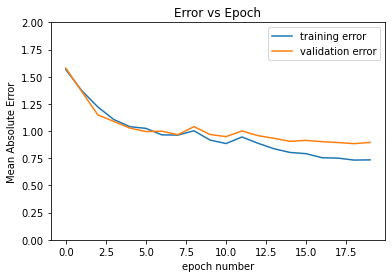

In [ ]:
    
    plt.plot(range(epochNumber), train_MAE_EpochArray, label = "training error") 
    plt.plot(range(epochNumber), validate_MAE_EpochArray, label = "validation error")  
    plt.ylim([0,2.0])
    plt.xlabel('epoch number') 
    plt.ylabel('Mean Absolute Error') 
    plt.title('Error vs Epoch') 
    plt.legend()   
    plt.show()

In [ ]:
    #prediction= sess.run([y_], feed_dict={keep_prob : 1.0, x: testData[1], y: testLabels[1]})
    #print(prediction)

init_op = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init_op)
    prediction= sess.run(y_, feed_dict={keep_prob : 1.0, x: testData[1:8,:], y: testLabels[1:8]})

    print(prediction)  
    print(testImageNames[1:8])
    plt.imshow(testData[1:8,:].reshape([80, 80, 3])/255)
    plt.show()

[[4.0128465]
 [4.0128255]
 [4.0128274]
 [4.0128384]
 [4.012825 ]
 [4.01283  ]
 [4.0128293]]
['4_AM967.jpg', '3_CM285.jpg', '4_AF908.jpg', '2_AF884.jpg', '5_CF747.jpg', '4_AF1281.jpg', '4_AM563.jpg']


ValueError: ignored

In [ ]:
print(beta)

0.01


# REFERENCE

https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-tensorflow/